In [447]:
from repair_system import RepairSystem
import matplotlib.pyplot as plt
import numpy.random as rng
import numpy as np
import scipy.stats as stats

In [448]:
class ModelConfig:
    def __init__(self, n_operating, n_spares, breakdown_gen, repair_gen, label):
        self.n_operating = n_operating
        self.n_spares = n_spares
        self.breakdown_gen = breakdown_gen
        self.repair_gen = repair_gen
        self.label = label

class CrashTimeAnalysis:
    def __init__(self, average: float, stdev: float, error_bound: float, sample_size: int, sample: list[float]):
        self.average = average
        self.stdev = stdev
        self.error_bound = error_bound
        self.sample_size = sample_size
        self.sample = sample

    def __str__(self) -> str:
        return (
            f"System total failure times ({self.sample_size} runs):\n"
            f"Mean: {self.average:.2f}\n"
            f"Standard Deviation: {self.stdev:.2f}\n"
            f"Error Bound: {self.error_bound:.2f}"
        )

ACCEPTED_ERROR = 1/3
CONFIDENCE_LEVEL = 0.95

rate_fail = 1/2
rate_repair = 1/2

repair_gen = lambda: rng.exponential(rate_fail)
breakdown_gen = lambda: rng.exponential(rate_repair)


In [449]:
def simulate_crash_times(config: ModelConfig, runs: int) -> list[float]:
    times = []
    for _ in range(runs):
        system = RepairSystem(config.n_operating, config.n_spares, config.breakdown_gen, config.repair_gen)
        times.append(system.run())
    return times

def analyze_crash_times(model_config: ModelConfig, accepted_error: float, confidence_level: float, initial_runs: int = 500, batch_runs: int = 100) -> CrashTimeAnalysis:
    z_value = stats.norm.ppf((1 + confidence_level) / 2)  # z_value for the confidence level

    def error_bound(stdev: float, n: int) -> float:
        return 2 * z_value * (stdev / np.sqrt(n))

    crash_times = simulate_crash_times(model_config, initial_runs)
    n = len(crash_times)
    mean_time = np.mean(crash_times)
    std_time = np.std(crash_times, ddof=1)
    eb = error_bound(std_time, n)

    while eb > accepted_error:
        print(f"Error bound {eb:.2f} > {accepted_error:.2f}: simulating {batch_runs} more runs...")
        more = simulate_crash_times(model_config, batch_runs)
        crash_times.extend(more)
        n = len(crash_times)
        mean_time = np.mean(crash_times)
        std_time = np.std(crash_times, ddof=1)
        eb = error_bound(std_time, n)

    return CrashTimeAnalysis(average=mean_time, stdev=std_time, error_bound=eb, sample_size=n, sample=crash_times)


In [450]:
model_config_1 = ModelConfig(n_operating=5, n_spares=2, breakdown_gen=breakdown_gen, repair_gen=repair_gen, label="5 operating units, 2 spares")

data_1 = analyze_crash_times(model_config=model_config_1, accepted_error=ACCEPTED_ERROR, confidence_level=CONFIDENCE_LEVEL)

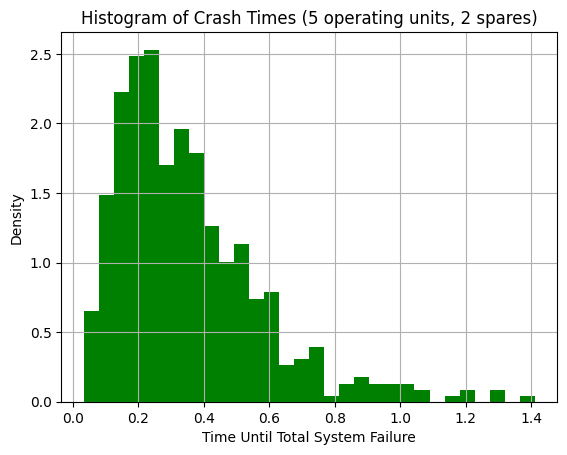

In [451]:
plt.hist(data_1.sample, bins=30, color='g', density=True)
plt.title(f"Histogram of Crash Times ({model_config_1.label})")
plt.xlabel("Time Until Total System Failure")
plt.ylabel("Density")
plt.grid()
plt.show()

In [452]:
model_config_2 = ModelConfig(n_operating=5, n_spares=3, breakdown_gen=breakdown_gen, repair_gen=repair_gen, label="5 operating units, 3 spares")

data_2 = analyze_crash_times(model_config_2, ACCEPTED_ERROR, CONFIDENCE_LEVEL)


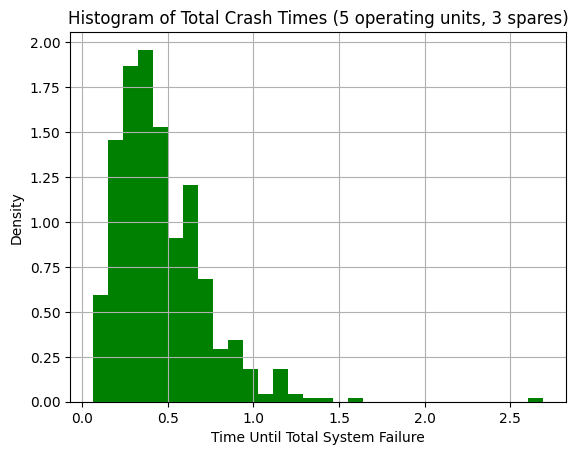

In [453]:
plt.hist(data_2.sample, bins=30, color='g', density=True)
plt.title(f"Histogram of Total Crash Times ({model_config_2.label})")
plt.xlabel("Time Until Total System Failure")
plt.ylabel("Density")
plt.grid(True)
plt.show()

Z-statistic: -3.41
Critical Value: +- 1.96


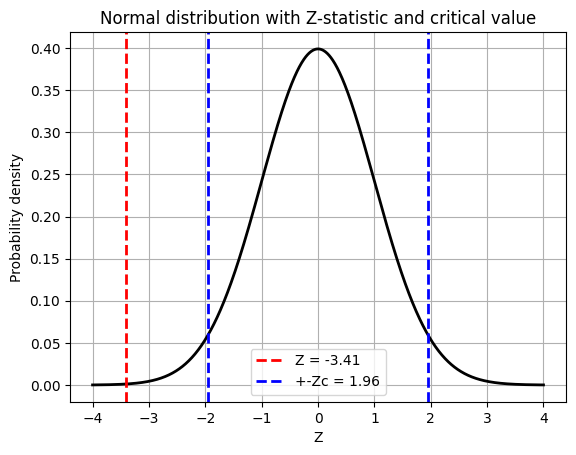

In [454]:
def calculate_z_statistic(avg1, var1, n1, avg2, var2, n2):
    return (avg1 - avg2) / ((var1 / n1 + var2 / n2) ** 0.5)

def calculate_critical_value(confidence_level: float):
    return stats.norm.ppf((1 + confidence_level) / 2)

def plot_normal_distribution(z_statistic: float, critical_value: float):
    x = np.linspace(-4, 4, 1000)
    p = stats.norm.pdf(x, 0, 1)

    plt.plot(x, p, 'k', linewidth=2)
    plt.axvline(z_statistic, color='r', linestyle='--', linewidth=2, label=f'Z = {z_statistic:.2f}')
    plt.axvline(critical_value, color='b', linestyle='--', linewidth=2, label=f'+-Zc = {critical_value:.2f}')
    plt.axvline(-critical_value, color='b', linestyle='--', linewidth=2)
    plt.title('Normal distribution with Z-statistic and critical value')
    plt.legend()
    plt.xlabel('Z')
    plt.ylabel('Probability density')
    plt.grid(True)
    plt.show()

mean_1 = data_1.average
stdev_1 = data_1.stdev
sample_size_1 = data_1.sample_size

mean_2 = data_2.average
stdev_2 = data_2.stdev
sample_size_2 = data_2.sample_size

z_statistic = calculate_z_statistic(mean_1, stdev_1, sample_size_1, mean_2, stdev_2, sample_size_2)
critical_value = calculate_critical_value(CONFIDENCE_LEVEL)

print(f"Z-statistic: {z_statistic:.2f}")
print(f"Critical Value: +- {critical_value:.2f}")

plot_normal_distribution(z_statistic, critical_value)

In [455]:
model_config_3 = ModelConfig(n_operating=6, n_spares=1, breakdown_gen=breakdown_gen, repair_gen=repair_gen, label="6 operating units, 1 spare")
model_config_4 = ModelConfig(n_operating=6, n_spares=4, breakdown_gen=breakdown_gen, repair_gen=repair_gen, label="6 operating units, 4 spares")

data_3 = analyze_crash_times(model_config=model_config_3, accepted_error=ACCEPTED_ERROR, confidence_level=CONFIDENCE_LEVEL)
data_4 = analyze_crash_times(model_config=model_config_4, accepted_error=ACCEPTED_ERROR, confidence_level=CONFIDENCE_LEVEL)

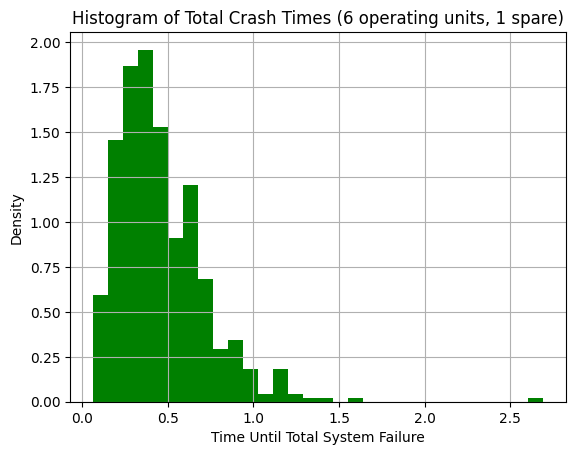

In [456]:
plt.hist(data_2.sample, bins=30, color='g', density=True)
plt.title(f"Histogram of Total Crash Times ({model_config_3.label})")
plt.xlabel("Time Until Total System Failure")
plt.ylabel("Density")
plt.grid(True)
plt.show()

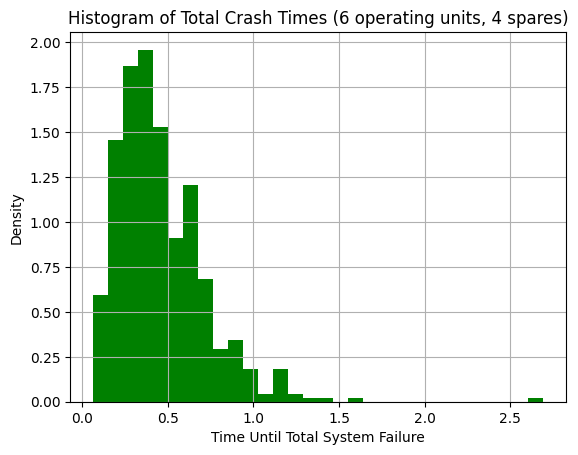

In [457]:
plt.hist(data_2.sample, bins=30, color='g', density=True)
plt.title(f"Histogram of Total Crash Times ({model_config_4.label})")
plt.xlabel("Time Until Total System Failure")
plt.ylabel("Density")
plt.grid(True)
plt.show()

Z-statistic: -11.48
Critical Value: +- 1.96


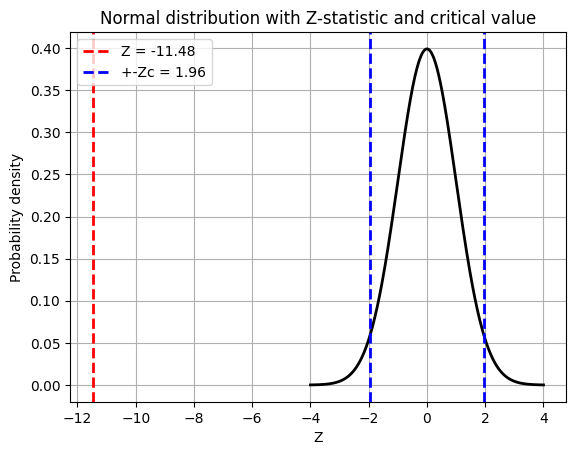

In [458]:
mean_3 = data_3.average
stdev_3 = data_3.stdev
sample_size_3 = data_3.sample_size

mean_4 = data_4.average
stdev_4 = data_4.stdev
sample_size_4 = data_4.sample_size

z_statistic = calculate_z_statistic(mean_3, stdev_3, sample_size_3, mean_4, stdev_4, sample_size_4)
critical_value = calculate_critical_value(CONFIDENCE_LEVEL)

print(f"Z-statistic: {z_statistic:.2f}")
print(f"Critical Value: +- {critical_value:.2f}")

plot_normal_distribution(z_statistic, critical_value)